In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
experimento = "exp/1/"

In [4]:
arch_train_prefijo = "datasets/emp3_sellout_train_cluster_"
arch_min_max_prod_cust = "datasets/emp3_min_max_prod_cust.csv"
arch_mean_std_prod = "datasets/emp3_mean_std_prod.csv"
arch_prod_ids_prediccion = "datasets/productos_a_predecir.csv"
arch_predicciones_full = experimento + "emp3_lightgbm_prediccion_full.csv"
arch_predicciones_simple = experimento + "emp3_lightgbm_prediccion.csv"

In [5]:
tipos_transf = ['sin_transformacion', 'normalizacion', 'estandarizacion']
GLOBAL_TRANSF = tipos_transf[1]
CANT_ITERACIONES_OPT_BAY = 5
CANT_SEMILLAS = 10
CANT_CLUSTERS = 5
MAX_BIN_PARAM=255
#MAX_BIN_PARAM=1023

GLOBAL_PROD_CUST_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [6]:
# Marco en train, holdout y descartar para considerarlo en las transformaciones
periodo_inicio=201701 #inclusive
train_periodo_limite = 201810 #inclusive
validate_periodo = 201812
train_all_periodo_limite = 201812 #inclusive
holdout_periodo = 201902

In [7]:
########### NORMALIZACION
def normalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        if (maximo-minimo)==0: 
            return 0
        else:
            return (valor - minimo) / (maximo-minimo)

        
def desnormalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        return (valor * (maximo-minimo)) + minimo

def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["prod_cust","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod_cust = df_train.groupby('prod_cust')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod_cust = df_min_max_prod_cust.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod_cust.to_csv(arch_min_max_prod_cust, index=False)
        
    df_ret = df_param.merge(df_min_max_prod_cust,how="left",on="prod_cust") #puede haber pares <prod-cust> que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Normalizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2","cust_request_tn"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: normalizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

############# ESTANDARIZACION
def estandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        if desvio==0: 
            return 0
        else:
            return (valor - media) / desvio

def desestandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        return (valor * desvio) + media
    
def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod = df_train.groupby('product_id')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod.columns = ["product_id",'valor_1', 'valor_2']
    df_mean_std_prod.to_csv(arch_mean_std_prod, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod,how="left",on="product_id")
    
    # Selecciono columnas a estandarizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Estandarizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: estandarizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

################### TRANSFORMACION    
def transformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return normalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return estandarizar_valor(valor,var1,var2)
    else:
        return valor

def destransformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return desnormalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return desestandarizar_valor(valor,var1,var2)
    else:
        return valor

def graficar_ejemplo_transformacion(df_param):
    prod_cust = np.array(df_param.sample(1).prod_cust)[0]
    df_param = df_param[df_param.prod_cust==prod_cust]
    
    plt.plot(df_param.tn_original)
    plt.title("Original - " + prod_cust)
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado - " + prod_cust)
    plt.show()

In [8]:
def semillerio(lgbtrain_all, lgb_params, best_iteration, X_holdout, y_holdout):
    er_holdout_list = []
    y_pred_holdout_list = []

    for i in range(0,CANT_SEMILLAS):
        seed = random.randint(1,99999999999999)
        lgb_params_new = {**lgb_params, **{"seed":seed}}

        final_model = lgb.train(lgb_params_new, lgbtrain_all, num_boost_round=best_iteration)

        y_pred_holdout = final_model.predict(X_holdout)
        er_holdout = error_rate(y_holdout,y_pred_holdout)

        y_pred_holdout_list.append(y_pred_holdout)
        er_holdout_list.append(er_holdout)

    #min(er_holdout_list),max(er_holdout_list),round(np.mean(er_holdout_list),2),round(np.median(er_holdout_list),2), round(np.std(er_holdout_list),2)
    y_pred_holdout_semillerio = np.sum(y_pred_holdout_list,axis=0)/CANT_SEMILLAS
    er_holdout_semillerio = error_rate(y_holdout,y_pred_holdout_semillerio)
    return er_holdout_semillerio

In [9]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prod_custs(prod_cust_values, y_vector):
    # Ademas del id y los valores para "destransformar", se deja el tn original porque la destransformacion puede no ser
    # precisa para <productos,cliente> que no estaban en train
    GLOBAL_PROD_CUST_IDS = pd.DataFrame(data={"prod_cust":prod_cust_values, "tn_orig":np.array(y_vector)})
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.merge(df_prod_cust_val1_val2,how="left",on="prod_cust")
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.sort_values(by="prod_cust",ascending=True)
    
    return GLOBAL_PROD_CUST_IDS

In [10]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Solamente destransformo la prediccion (para el y tomo el original de la columna tn_orig)
    df_calculo = GLOBAL_PROD_CUST_IDS.copy()
    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.tn_orig
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [11]:
def destransformar_vector(y_vector):
    df_calculo = GLOBAL_PROD_CUST_IDS.copy()
    df_calculo["y"] = y_vector
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    return df_calculo.y_destransformado

In [12]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [13]:
def objective(trial):

    lgb_params = {
        'objective': 'tweedie', #'regression', #
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': MAX_BIN_PARAM,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.2,0.5,0.9]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [14]:
##############################################

Cluster: 0
<prod-cust> a validar: 108
<prod-cust> a testear: 120
Normalizacion
4020
4020


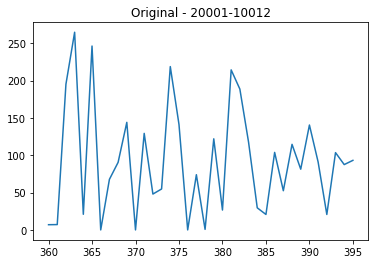

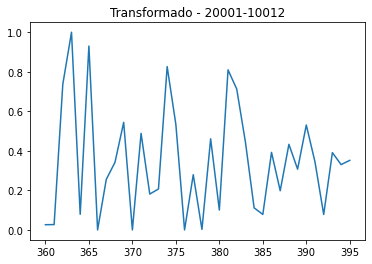

[I 2023-12-03 14:48:24,715] A new study created in memory with name: no-name-404dc434-cbfd-4877-baf0-91a66645fdb9
[LightGBM] [Fatal] [tweedie]: at least one target label is negative
[W 2023-12-03 14:48:24,733] Trial 0 failed with parameters: {'learning_rate': 0.2, 'num_leaves': 861, 'feature_fraction': 0.5, 'min_data_in_leaf': 5} because of the following error: LightGBMError('[tweedie]: at least one target label is negative').
Traceback (most recent call last):
  File "/home/dcastro_contacto/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_7325/258035343.py", line 33, in objective
    model = lgb.train(lgb_params, lgb_train,
  File "/home/dcastro_contacto/.local/lib/python3.10/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/home/dcastro_contacto/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 2610, in __ini

<prod-cust> a validar: 108
<prod-cust> a testear: 120
Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810]
Periodos validar: [201812]
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812]
Periodos holdout: [201902]
X_train: (2376, 29)
y_train: (2376,)

X_validate: (108, 29)
y_validate: (108,)

X_train_all: (2592, 29)
y_train_all: (2592,)

X_holdout: (120, 29)
y_holdout: (120,)


LightGBMError: [tweedie]: at least one target label is negative

In [15]:
clusters_final_models = []
clusters_er_holdout = []
clusters_predictions = []
clusters_final_params = []
clusters_final_best_iter = []

########################
CANT_CLUSTERS = 1
########################

for cluster_iter in range(0,CANT_CLUSTERS+1):
    print("Cluster:",cluster_iter)
    
    ### Se levanta el dataset de cada cluster
    df_sellout = pd.read_csv(arch_train_prefijo + str(cluster_iter) + ".csv")

    ### Antes de transformar, se guardan los y_validate y holdout originales (se van a usar en el vector global)
    # Esto se debe a que la "destransformacion" no siempre es perfecta, considerando productos que no estuvieron en train
    df_sellout_validate_orig = df_sellout[df_sellout.periodo==validate_periodo]
    df_sellout_validate_orig = df_sellout_validate_orig.sort_values(by="prod_cust",ascending=True)
    y_validate_orig = df_sellout_validate_orig.tn_mas_2
    print("<prod-cust> a validar:", len(y_validate_orig))
    
    df_sellout_holdout_orig = df_sellout[df_sellout.periodo==holdout_periodo]
    df_sellout_holdout_orig = df_sellout_holdout_orig.sort_values(by="prod_cust",ascending=True)
    y_holdout_orig = df_sellout_holdout_orig.tn_mas_2
    print("<prod-cust> a testear:", len(y_holdout_orig))

    ### Transformacion
    if GLOBAL_TRANSF == "sin_transformacion":
        print("\nSin Transformacion")
             
        df_sellout_transf = df_sellout
            
        df_prod_cust_val1_val2 = pd.DataFrame(data={"prod_cust":df_sellout.prod_cust.unique()})
        df_prod_cust_val1_val2["valor_1"]=0
        df_prod_cust_val1_val2["valor_2"]=0
        
    elif GLOBAL_TRANSF == "normalizacion":
        print("Normalizacion")
        print(len(df_sellout))
        df_sellout_transf = normalizar_tn(df_sellout)
        print(len(df_sellout_transf))
    
        graficar_ejemplo_transformacion(df_sellout_transf)
        df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
        
        df_prod_cust_val1_val2 = pd.read_csv(arch_min_max_prod_cust)
    
#    elif GLOBAL_TRANSF == "estandarizacion":
#        print("Estandarizacion")
#        df_sellout_transf = estandarizar_tn(df_sellout)
#        graficar_ejemplo_transformacion(df_sellout_transf)
#        df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
       
#        df_prod_cust_val1_val2 = pd.read_csv(arch_mean_std_prod)

    ### Categoricas
    #Transformo todas las categoricas
    categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id","customer_id","prod_cust","cero_ventas"]
    
    for c in categories: 
        df_sellout_transf[c] = df_sellout_transf[c].astype("category")   
        
    ### Se descartan variables no utiles para la prediccion
    df_sellout_transf = df_sellout_transf.drop(columns=["brand","periodo_fecha"])

    ### Split de datasets
    df_train = df_sellout_transf[(df_sellout_transf.periodo <= train_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
    df_validate = df_sellout_transf[df_sellout_transf.periodo == validate_periodo]
    
    df_train_all = df_sellout_transf[(df_sellout_transf.periodo <= train_all_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
    df_holdout = df_sellout_transf[df_sellout_transf.periodo == holdout_periodo]
    
    df_validate = df_validate.sort_values(by="prod_cust",ascending=True)
    print("<prod-cust> a validar:", len(df_validate))
    
    df_holdout = df_holdout.sort_values(by="prod_cust",ascending=True)
    print("<prod-cust> a testear:", len(df_holdout))

    print("Periodos entrenar:",df_train.periodo.unique())
    print("Periodos validar:",df_validate.periodo.unique())
    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    ### Armado variables entrenamiento
    # Train - Validate
    X_train = df_train.drop(columns=["tn_mas_2","periodo"], axis=1)
    X_validate = df_validate.drop(columns=["tn_mas_2","periodo"], axis=1)
    
    y_train = df_train.tn_mas_2
    y_validate = df_validate.tn_mas_2
    
    # Train All - Holdout
    X_train_all = df_train_all.drop(columns=["tn_mas_2","periodo"], axis=1)
    X_holdout = df_holdout.drop(columns=["tn_mas_2","periodo"], axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    
    print("\nX_validate:", X_validate.shape)
    print("y_validate:", y_validate.shape)
    
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    cols = X_train.columns.tolist()

    ### Optimizacion Bayesiana
    #Antes de entrenar, se setea vector global para validate
    GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(X_validate.prod_cust, y_validate_orig)
    
    GLOBAL_PARAMS_ITER = []
    GLOBAL_BEST_IT_ITER = []
    GLOBAL_ER_VALIDATE_ITER = []
    GLOBAL_MODEL_ITER = []
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=CANT_ITERACIONES_OPT_BAY)
    print('# Experimentos:', len(study.trials))
    print('Mejor experimento:', study.best_trial.params)

    best_model_index = study.best_trial.number
    best_model = GLOBAL_MODEL_ITER[best_model_index]
    plot_lgb_importances(best_model, num=30, plot=True)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols)

    final_params = GLOBAL_PARAMS_ITER[best_model_index]
    final_best_iter = GLOBAL_BEST_IT_ITER[best_model_index]
    final_model = lgb.train(final_params, lgbtrain_all, num_boost_round=final_best_iter)
    
    GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(X_holdout.prod_cust, y_holdout_orig)
    
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    print("Error Holdout:", er_holdout)

    prediction_with_prod_cust = pd.DataFrame(data={"prod_cust":X_holdout.prod_cust,"actual_value":y_holdout_orig,"predicted_value":y_pred_holdout})
    
    clusters_final_models.append(final_model)
    clusters_er_holdout.append(er_holdout)
    clusters_predictions.append(prediction_with_prod_cust)
    clusters_final_params.append(final_params)
    clusters_final_best_iter.append(final_best_iter)

In [ ]:
clusters_predictions

In [ ]:
## Se verifica transformacion
df_test = df_sellout_transf[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]].merge(df_prod_val1_val2,how="left",on="product_id")
df_test["tn"]=df_test.apply(lambda row: destransformar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_mas_2"]=df_test.apply(lambda row: destransformar_valor(row["tn_mas_2"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_lag_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_lag_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_delta_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_delta_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test = df_test.merge(df_sellout[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]],how="inner",on=["product_id","periodo"])
df_test[["product_id","periodo","tn_x","tn_y","tn_mas_2_x","tn_mas_2_y","tn_lag_1_x","tn_lag_1_y","tn_delta_1_x","tn_delta_1_y"]].head()




# Compruebo que no haya diferencias
df_test["dif"]=df_test.tn_x-df_test.tn_y
df_test[df_test.dif>1e-3]



df_test[df_test.tn_x.isna()]


In [ ]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

In [ ]:
df_prods_prediccion.info()

## Modelo Final

In [ ]:
print(X_holdout.shape)
df_prediccion = X_holdout.copy()
df_prediccion["tn_target"]=np.array(y_holdout_orig)
df_prediccion["tn_predicted"]=np.array(destransformar_vector(y_pred_holdout))
print(df_prediccion.shape)

In [ ]:
print("Toneladas Holdout:\t", df_prediccion.tn_target.sum())
print("Toneladas Prediccion:\t", df_prediccion.tn_predicted.sum())

In [ ]:
df_prediccion = df_prediccion.sort_values(by="product_id",ascending=True)
df_prediccion.to_csv(arch_predicciones_full, index=False)
df_prediccion[["product_id","tn_predicted"]].to_csv(arch_predicciones_simple, index=False)

In [ ]:
print("Error Rate Validate:",GLOBAL_ER_VALIDATE_ITER[best_model_index])
print("Error Rate Holdout:",er_holdout)

In [ ]:
# Armo resultados y calculo modelo final y semillerio para top 5 de error de validacion
df_resultado = pd.DataFrame(data={"error_rate_validation":GLOBAL_ER_VALIDATE_ITER,
                                  "best_iteration": GLOBAL_BEST_IT_ITER,
                                  "params":GLOBAL_PARAMS_ITER})
df_resultado["max_bin"]=MAX_BIN_PARAM

df_resultado = df_resultado.sort_values(by="error_rate_validation",ascending=True)

er_holdout_iter = [None] * len(df_resultado)
er_holdout_semillerio_iter = [None] * len(df_resultado)
for i in range(0,5):
    print("Iteración:",i)
    #Modelo Final (Sin Semillerio)
    final_model = lgb.train(df_resultado.iloc[i].params, lgbtrain_all, num_boost_round=df_resultado.iloc[i].best_iteration)
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    er_holdout_iter[i]=er_holdout
    
    #Semillerio
    er_holdout_semillerio_iter[i]=(semillerio(lgbtrain_all, df_resultado.iloc[i].params, df_resultado.iloc[i].best_iteration, X_holdout, y_holdout))

df_resultado["error_rate_holdout"]=er_holdout_iter    
df_resultado["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    
    
datetime_string = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M')
df_resultado.to_excel("resultados_opt_bay_"+GLOBAL_TRANSF+"_"+str(CANT_ITERACIONES_OPT_BAY)+"_"+datetime_string+".xlsx",index=False)

In [ ]:
df_resultado

4020


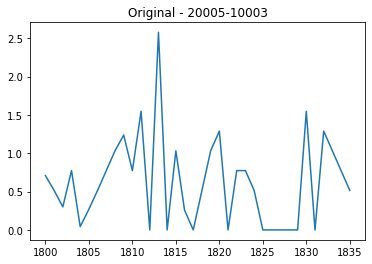

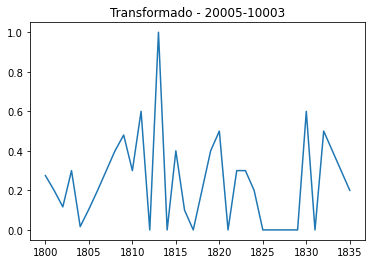

In [20]:
df_sellout_transf = normalizar_tn(df_sellout)
print(len(df_sellout_transf))

graficar_ejemplo_transformacion(df_sellout_transf)

In [25]:
a = df_sellout_transf[["prod_cust","tn","tn_original","tn_mas_2","valor_1","valor_2"]]

In [26]:
a[a.tn < 0]

,prod_cust,tn,tn_original,tn_mas_2,valor_1,valor_2
67,20001-10002,-0.01,0.00,0.28,0.76,59.18
100,20001-10003,-0.01,1.85,0.50,3.33,275.57
101,20001-10003,-0.01,0.00,0.58,3.33,275.57
132,20001-10004,-0.04,70.24,0.04,86.35,469.46
137,20001-10004,-0.05,66.72,0.03,86.35,469.46
...,...,...,...,...,...,...
3707,20011-10007,-0.02,2.23,NaN,2.88,40.34
3874,20011-10013,-0.01,0.00,0.23,0.79,59.75
3884,20011-10013,-0.01,0.00,-0.01,0.79,59.75
3885,20011-10013,-0.01,0.00,0.27,0.79,59.75


In [22]:
df_sellout_transf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 0 to 4019
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 4020 non-null   int64  
 1   periodo                    4020 non-null   int64  
 2   customer_id                4020 non-null   int64  
 3   cero_ventas                4020 non-null   int64  
 4   plan_precios_cuidados      4020 non-null   float64
 5   cust_request_tn            4020 non-null   float64
 6   tn                         4020 non-null   float64
 7   periodo_fecha              4020 non-null   object 
 8   mes                        4020 non-null   int64  
 9   meses_historia_prod        4020 non-null   int64  
 10  meses_historia_cliente     4020 non-null   int64  
 11  cliente_estrella           4020 non-null   int64  
 12  prod_cust                  4020 non-null   object 
 13  cat1                       4020 non-null   objec